## First, I'll load the required data and setup keras settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
# use non standard flow_from_directory
from utils.image_preprocessing_ver2 import ImageDataGenerator
# it outputs y_batch that contains embeddings

from utils.mobilenet import get_mobilenet
import keras
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import matplotlib.pyplot as plt
from keras.layers import Activation, GlobalAveragePooling2D, Dropout, Dense, Input
%matplotlib inline

/home/mina/anaconda3/envs/tensorflow/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mina/anaconda3/envs/tensorflow/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
#GPU memory is now allocated as and when needed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

In [4]:
face_emb_dir = '/media/mina/New Volume/Datasets/vggface2_test/face_emb/'

In [5]:
train_logits = np.load(face_emb_dir + 'train_set.npy')[()]
val_logits = np.load(face_emb_dir + 'test_set.npy')[()]
print(len(train_logits))

140729


In [ ]:
train_logits.keys()[0]

In [6]:
data_dir = "/media/mina/New Volume/Datasets/vggface2/mtcnnpy_160_split/"

In [7]:
def fixed_image_stand(image):
    return (tf.cast(image, tf.float32) - 127.5)/128

In [8]:
train_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function = fixed_image_stand
)

test_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function = fixed_image_stand
)

# note: i'm also passing dicts of logits
train_generator = train_generator.flow_from_directory(
    data_dir + 'train/', train_logits,
    target_size=(160, 160),
    batch_size=512,
    class_mode = 'embedding',
)

val_generator = test_generator.flow_from_directory(
    data_dir + 'test', val_logits,
    target_size=(160, 160),
    batch_size=512,
    class_mode = 'embedding',
)

Found 140729 images belonging to 1 classes.
Found 28449 images belonging to 1 classes.


## Create your Mobilenet model

In [141]:
def get_mobilenet(input_size = 160, alpha = 1 ):
    
    input_shape = (input_size, input_size, 3)
    base_model = MobileNet(
        include_top=False, weights='imagenet', 
        input_shape=input_shape, alpha=alpha
    )
    layers_change = ["conv_dw_13_relu", 'conv_pw_12_relu', 'conv_pw_13_relu']
    # Disassemble all the layers to add layers in between
    layers = [l for l in base_model.layers]
    print(len(layers))
    x = base_model.input 
    for i in range(1, len(layers)):
        layer = layers[i] 
        x=layer(x) 
        if(layer.get_config()['name'] in layers_change):
            x=Dropout(0.7)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    logits = Dense(512)(x)
    l2_norm = Lambda(lambda  x: K.l2_normalize(x,axis=1))(logits)
    model = Model(base_model.input, l2_norm)
    
    print(len(model.layers))
    for layer in model.layers[:-18]:
        layer.trainable = False
    return model

model = get_mobilenet()
print(model.summary())

96
103
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 162, 162, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 82, 82, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
___

In [145]:
def embedding_loss(y_true, y_pred):    
    return K.mean(K.sum(K.square(y_true - y_pred), axis = 1))

In [147]:

model.compile(
    optimizer=optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), #SGD has the best generalization capability
#     optimizer = optimizers.RMSprop(lr=1e-5),
    loss=embedding_loss, 
    metrics=[embedding_loss]
)

(?, ?)


In [ ]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=300, epochs=30, verbose=1,
    validation_data=val_generator, validation_steps=80, workers=4
)

Epoch 1/30
299/300 [============================>.] - ETA: 9s - loss: 0.1006 - mean_squared_error: 1.9654e-04 

### Loss/epoch plots

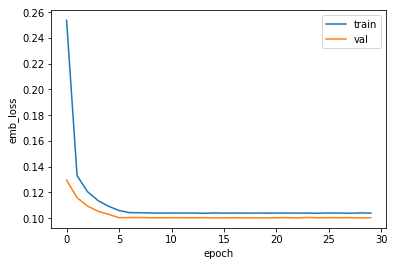

In [19]:
plt.plot(model.history.history['embedding_loss'], label='train');
plt.plot(model.history.history['val_embedding_loss'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('emb_loss');

### Save your model to disk

In [20]:
import time, datetime
model_dir = '/home/mina/Desktop/Models/keras/Mobilenet/'
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S')
model_name = timestamp + "_" + "train_" + str(len(train_logits)) + "_0.7_dropout_postBN_v3"
model.save(model_dir + model_name)

### Export as TF model

In [22]:
from keras import backend as K

K.set_learning_phase(0)  # all new operations will be in test mode from now on

# serialize the model and get its weights, for quick re-building
json_config = model.to_json()
weights = model.get_weights()

# re-build a model where the learning phase is now hard-coded to 0
from keras.models import model_from_json
new_model = model_from_json(json_config, {'relu6': keras.applications.mobilenet.mobilenet.relu6})
new_model.set_weights(weights)

In [24]:
tf_model_dir = '/home/mina/Desktop/Models/tf/Mobilenet/'
from  tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

sess = K.get_session()
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), [new_model.output.op.name])
graph_io.write_graph(constant_graph, tf_model_dir, model_name+".pb", as_text=False)
print('saved the freezed graph (ready for inference)')

INFO:tensorflow:Froze 137 variables.
INFO:tensorflow:Converted 137 variables to const ops.
saved the freezed graph (ready for inference)
